This is **📘ModelEvaluation.ipynb** notebook, which loads the trained models and evaluates them on the test set using AUC-PR, ROC-AUC, F1 score, and the confusion matrix especially considering the imbalance in the fraud data.

#### **🧾 1. Imports**

In [3]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Metrics and evaluation tools
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    f1_score,
    roc_curve,
    precision_recall_curve
)

#### **📂 2. Load Test Data and Preprocess**

In [4]:
# Load the engineered dataset
df = pd.read_csv("../../data/processed/engineered_fraud_data.csv")

# Separate features and target
X = df.drop(columns=['class'])
y = df['class']

# Perform the same train-test split used during training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Load the fitted scaler used during training
scaler = joblib.load("../../models/fraud_scaler.pkl")
X_test_scaled = scaler.transform(X_test)

#### **🧠 3. Load Trained Models**

In [5]:
# Load previously saved models
lr_model = joblib.load("../../models/logistic_regression_model.pkl")
rf_model = joblib.load("../../models/random_forest_model.pkl")

# Dictionary of models for convenience
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model
}

#### **📊 4. Evaluation Function**

In [6]:
# Define a reusable function to evaluate each model
def evaluate_model(name, model, X_test, y_test):
    # Predict class labels and probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_pr = average_precision_score(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Print performance
    print(f"📌 {name} Performance")
    print("-" * 30)
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")

    # Return results for visualization
    return {
        "Model": name,
        "F1 Score": f1,
        "AUC-PR": auc_pr,
        "ROC AUC": roc_auc
    }, y_prob

#### **✅ 5. Evaluate All Models**

In [7]:
# Store evaluation results and prediction probabilities
results = []
y_probs = {}

# Evaluate each model
for name, model in models.items():
    res, y_prob = evaluate_model(name, model, X_test_scaled, y_test)
    results.append(res)
    y_probs[name] = y_prob

📌 Logistic Regression Performance
------------------------------
F1 Score: 0.7043
AUC-PR: 0.6424
ROC AUC: 0.7787
Confusion Matrix:
[[23376     0]
 [ 1120  1334]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     23376
           1       1.00      0.54      0.70      2454

    accuracy                           0.96     25830
   macro avg       0.98      0.77      0.84     25830
weighted avg       0.96      0.96      0.95     25830



📌 Random Forest Performance
------------------------------
F1 Score: 0.7043
AUC-PR: 0.6319
ROC AUC: 0.7666
Confusion Matrix:
[[23376     0]
 [ 1120  1334]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     23376
           1       1.00      0.54      0.70      2454

    accuracy                           0.96     25830
   macro avg       0.98      0.77      0.84     25830
weighted avg       0.96      0.96  

#### **📉 6. Visualize Model Performance Comparison**

C:\Users\Admin\AppData\Local\Temp\ipykernel_9888\1836813208.py:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


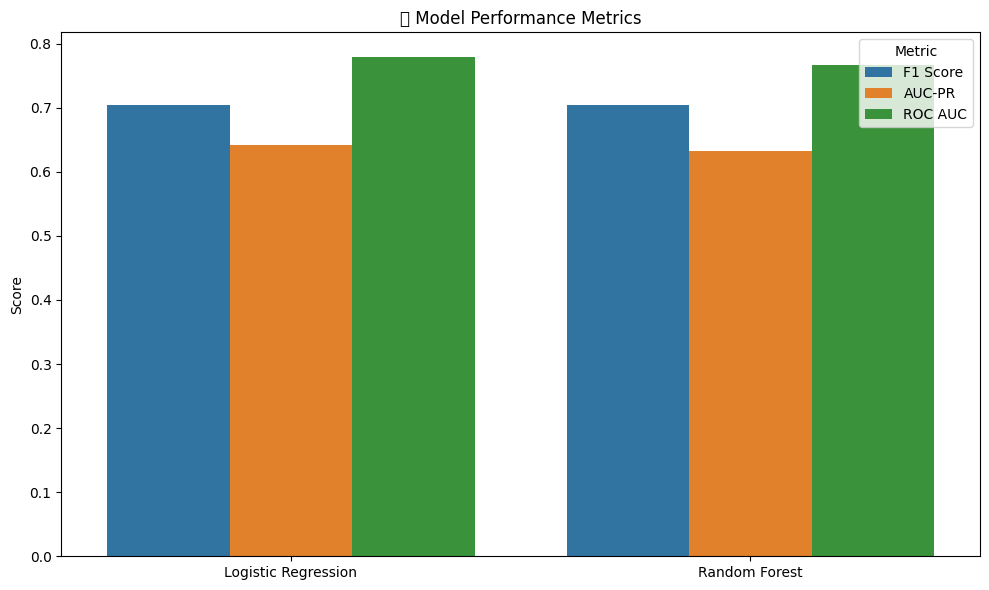

In [8]:
# Convert results into a DataFrame for visualization
results_df = pd.DataFrame(results)

# Create a barplot for F1, AUC-PR, and ROC AUC
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("📊 Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

#### **📈 7. Plot ROC & Precision-Recall Curves**

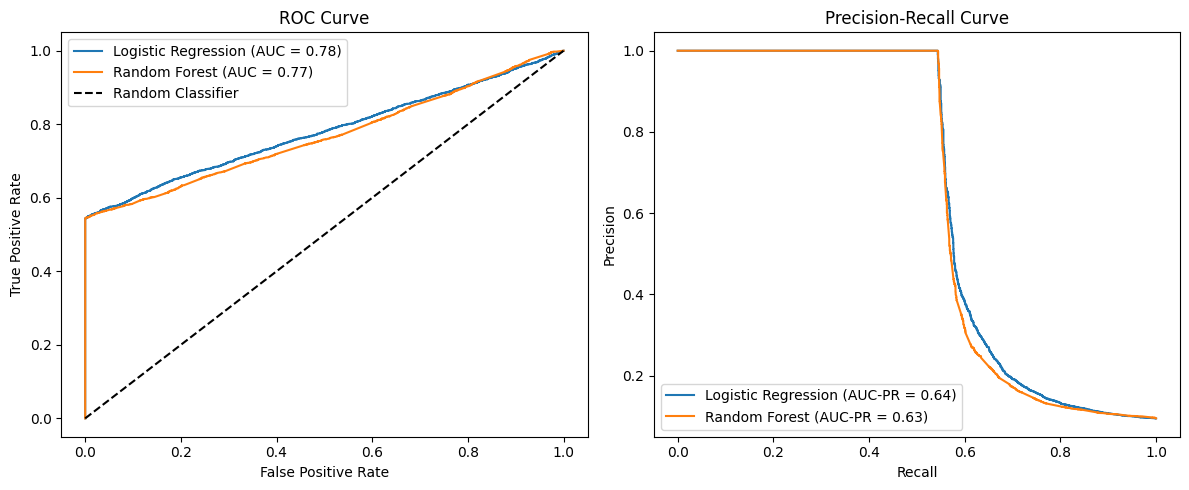

In [9]:
plt.figure(figsize=(12, 5))

# ----- ROC Curve -----
plt.subplot(1, 2, 1)
for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, y_probs[name])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_probs[name]):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# ----- Precision-Recall Curve -----
plt.subplot(1, 2, 2)
for name in models.keys():
    precision, recall, _ = precision_recall_curve(y_test, y_probs[name])
    plt.plot(recall, precision, label=f"{name} (AUC-PR = {average_precision_score(y_test, y_probs[name]):.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()